# Реализация Fast R-CNN
Воспользуемся датасетом MNIST и создадим на его основе детекционный датасет, который будет сосотять из изображений, на которых будет располагаться произвольное количество цифр из MNIST.

Для работы Fast R-CNN потребуются две состовляющее: Region Proposals (пропозалы) и классификатор. Для простоты демонстрации в качестве пропозалов будем использовать сгенерированные "фейковые" пропозалы, полученные по известным ground-truth боксам. В идеале за их создание должен был бы отвечать какой-то сторонний алгоритм.

In [2]:
import random
import numpy as np
import skimage.filters
from skimage.transform import resize

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.6.0


# Подготовка датасета

### Загрузка оригинального датасета MNIST
Загружаем датасет MNIST (train и test) и приводим данные к удобному формату:
* Размер: (N, 28, 28, 1), где N - количество образцов в подвыборке
* Значения интесивности: float32 в диапазоне [0, 1]

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


### Подготовка фона для для новых изображений

In [4]:
bg_source = np.random.rand(1000, 1000, 1).astype(np.float32)
bg_source = skimage.filters.gaussian(bg_source, 4)
bg_source = (bg_source - np.min(bg_source))/(np.max(bg_source) - np.min(bg_source))
bg_source = np.clip(bg_source, 0, 1)

### Функция генерации датасета для задачи детектирования объектов
Функция `gen_od_ds`, в которую передается подвыборка (train или test) картинок из MNIST (x) и правильных классификационных ответов (y). Задача функции сгенерировать новый датасет, состоящий из картинок размера `new_size`. Для создания каждой новой картинки используется случайный кусочек фона из bg_source, а затем помещается несколько цифр из MNIST на случайные места в новой картинке. Количество цифр тоже выбирается случайно.

In [5]:
def gen_od_ds(x, y, bg_source, new_size, num_samples, max_num_objects):
    x_new = np.zeros((num_samples, new_size[0], new_size[1], 1), dtype=np.float32)
    y_new = []
    
    rh = float(x.shape[1]) / new_size[0]
    rw = float(x.shape[2]) / new_size[1]
    
    for i in range(num_samples):
        oh = random.randint(0, bg_source.shape[0] - new_size[0])
        ow = random.randint(0, bg_source.shape[1] - new_size[1])
        x_new[i] = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]
        num_of_objects = random.randint(1, max_num_objects)
        y_new.append([])
        for _ in range(num_of_objects):
            sample_idx = random.randint(0, x.shape[0]-1)
            xs = x[sample_idx]
            ys = y[sample_idx]
            ofs = (random.randint(0, x_new[i].shape[0]-xs.shape[0]),
                   random.randint(0, x_new[i].shape[1]-xs.shape[1]))
            x_new[i][ofs[0]:ofs[0]+xs.shape[0], ofs[1]:ofs[1]+xs.shape[1], :] += xs
            ry = float(ofs[0]) / new_size[0]
            rx = float(ofs[1]) / new_size[1]
            y_new[-1].append([ys, ry, rx, rh, rw])
            
        x_new[i] = np.clip(x_new[i], 0.0, 1.0)
        
    return x_new, y_new

### Генерация датасета для детектирования объектов
Размер новых картинок (`new_size`) возьмем 128x128

In [6]:
new_size = (128, 128)
train_num_samples = 60000
test_num_samples = 10000
max_num_objects = 3 # максимальное кол-во цифр на одном изображении

train_x_det, train_y_det = gen_od_ds(train_x, train_y, bg_source, new_size, train_num_samples, max_num_objects)
test_x_det, test_y_det = gen_od_ds(test_x, test_y, bg_source, new_size, test_num_samples, max_num_objects)

print(train_x.shape)
print(len(train_y))
print(test_x.shape)
print(len(test_y))

(60000, 28, 28, 1)
60000
(10000, 28, 28, 1)
10000


### Фнкция для отображения детекций

In [7]:
def show_prediction(img, preds):
    import matplotlib.patches as patches
    
    fig,ax = plt.subplots(1)
    ax.imshow(img[...,0], 'gray', vmin=0, vmax=1,)
    
    for pred in preds:

        pred_cls = pred[0]
        ry, rx, rh, rw = pred[1:]
        
        box_y = int(ry * img.shape[0])
        box_x = int(rx * img.shape[1])
        box_w = int(rw * img.shape[1])
        box_h = int(rh * img.shape[0])

        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        rect = patches.Rectangle((box_x, box_y), 10, -10, linewidth=1, edgecolor='r', facecolor='r')
        ax.add_patch(rect)
        ax.text(box_x+4, box_y-2, pred_cls)

### Визуализация Ground-Truth образца

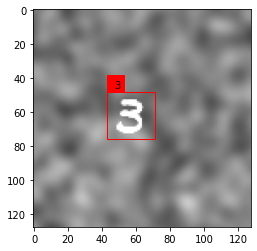

In [8]:
idx = 0
show_prediction(train_x_det[idx], train_y_det[idx])

# Детектирование объектов с помощью Fast R-CNN

### Функция для генерации пропозалов

In [9]:
def gen_fake_proposals(x_det, y_det, ori_shape, num_proposals):
    all_proposals = []
    for boxes in y_det:
        proposals = []
        for box in boxes:
            proposals.append(box[1:])
        extra_prop_num = num_proposals - len(proposals)
        for _ in range(extra_prop_num):
            proposal_shape = (ori_shape[0] + random.randint(-8, 8), 
                              ori_shape[1] + random.randint(-8, 8))
            ofs = (random.randint(0, x_det.shape[1]-proposal_shape[0]),
                   random.randint(0, x_det.shape[2]-proposal_shape[1]))

            rh = float(proposal_shape[0]) / x_det.shape[1]
            rw = float(proposal_shape[1]) / x_det.shape[2]            
            ry = float(ofs[0]) / x_det.shape[1]
            rx = float(ofs[1]) / x_det.shape[2]
            proposals.append([ry, rx, rh, rw])
        
        random.shuffle(proposals)                              
        all_proposals.append(proposals)
        
    return all_proposals

### Генерация пропозалов

In [10]:
ori_shape = (28, 28)
num_proposals = 8 # количество пропозалов на одну картинку

test_proposals = gen_fake_proposals(test_x_det, test_y_det, ori_shape, num_proposals)

for p in test_proposals[0]:
    print(p)

[0.2421875, 0.4765625, 0.234375, 0.234375]
[0.40625, 0.4765625, 0.2578125, 0.28125]
[0.546875, 0.046875, 0.15625, 0.2734375]
[0.5703125, 0.4453125, 0.21875, 0.21875]
[0.0546875, 0.359375, 0.2578125, 0.171875]
[0.15625, 0.015625, 0.21875, 0.21875]
[0.09375, 0.1796875, 0.2109375, 0.2578125]
[0.3125, 0.2265625, 0.2109375, 0.2265625]


### Функция для визуализации пропозалов

In [11]:
def show_proposals(img, proposals):
    import matplotlib.patches as patches
    
    fig,ax = plt.subplots(1)
    ax.imshow(img[...,0], 'gray', vmin=0, vmax=1,)
    
    for proposal in proposals:

        ry, rx, rh, rw = proposal
        
        box_y = int(round(ry * img.shape[0]))
        box_x = int(round(rx * img.shape[1]))
        box_w = int(round(rw * img.shape[1]))
        box_h = int(round(rh * img.shape[0]))

        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

### Пример визуализации пропозалов для одного изображения

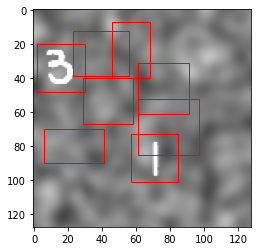

In [12]:
idx = 0
show_proposals(test_x_det[idx], test_proposals[idx])

### Функция для создания обучающего датасета

In [13]:
def gen_classification_ds(x_det, y_det, inp_size, bg_source, bg_samples_num):
    imgs = []
    labels = []
    for i in range(len(x_det)):
        if i % 10000 == 0:
            print('[{} / {}]'.format(i, len(x_det)))
        img = x_det[i]
        for box in y_det[i]:
            pred_cls = box[0]
            ry, rx, rh, rw = box[1:]

            box_y = int(round(ry * img.shape[0]))
            box_x = int(round(rx * img.shape[1]))
            box_w = int(round(rw * img.shape[1]))
            box_h = int(round(rh * img.shape[0]))
            img_sub = img[box_y:box_y+box_h, box_x:box_x+box_w, :]     
            if img_sub.shape[0] == inp_size[0] and img_sub.shape[1] == inp_size[1]:
                img_inp = img_sub
            else:
                img_inp = resize(img_sub, (inp_size[0], inp_size[1]), 
                    order=3, mode='reflect', anti_aliasing=True)
            imgs.append(img_inp)
            labels.append(pred_cls)
            
    for i in range(bg_samples_num):
        if i % 10000 == 0:
            print('[{} / {}]'.format(i, bg_samples_num))
        ofs = (random.randint(0, bg_source.shape[0]-inp_size[0]),
               random.randint(0, bg_source.shape[1]-inp_size[1]))
        imgs.append(bg_source[ofs[0]:ofs[0]+inp_size[0], ofs[1]:ofs[1]+inp_size[1], :])
        labels.append(10) # bg
            
    x_cls = np.stack(imgs)
    y_cls = np.stack(labels)
    return x_cls, y_cls

### Создание обучающего датасета


In [14]:
bg_samples_num = 100000 # Количество образцов класса "фон"
inp_size = (28, 28) # Размер входа в нейросеть

train_x_cls, train_y_cls = gen_classification_ds(train_x_det, train_y_det, inp_size, bg_source, bg_samples_num)

[0 / 60000]
[10000 / 60000]
[20000 / 60000]
[30000 / 60000]
[40000 / 60000]
[50000 / 60000]
[0 / 100000]
[10000 / 100000]
[20000 / 100000]
[30000 / 100000]
[40000 / 100000]
[50000 / 100000]
[60000 / 100000]
[70000 / 100000]
[80000 / 100000]
[90000 / 100000]


### Создание классификационной модели

In [29]:
NUM_CLASSES = 11

class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        
    def call(self, inp, proposals=None):
        
        if proposals is None: # Режим обучения
          
            out = self.conv1(inp)
            out = self.max_pool(out)
            out = self.conv2(out)
            out = self.max_pool(out)
            out = tf.keras.layers.Flatten()(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
          
        else: # Режим предсказания
          
            assert inp.shape[0] == 1 # Только batch size = 1
            predictions = []
            roi_pool_size = (7, 7)
            
            # Извлечение признаков из всей картинки
            out = self.conv1(inp)
            out = self.max_pool(out)
            out = self.conv2(out)
            feat = self.max_pool(out)
            
            # Для каждого пропозала
            for proposal in proposals:
                
                # Отображение координат пространства изображения 
                # в координаты пространства признаков
                ry, rx, rh, rw = proposal        
                box_y = int(round(ry * int(feat.shape[1])))
                box_x = int(round(rx * int(feat.shape[2])))
                box_w = int(round(rw * int(feat.shape[2])))
                box_h = int(round(rh * int(feat.shape[1])))
                
                # Вырезаем признаки, относящиеся к пропозалу
                feat_sub = feat[:, box_y:box_y+box_h, box_x:box_x+box_w, :]
                
                # Аналог ROI Pooling
                feat_pooled = tf.image.resize(
                    feat_sub, 
                    (roi_pool_size[0], roi_pool_size[1]), 
                    tf.image.ResizeMethod.BILINEAR)
                
                # Финальная классификация
                out = tf.keras.layers.Flatten()(feat_pooled)
                out = self.fc1(out)
                out = self.fc2(out)
                
                # Фильтрация класса "фон"
                assert out.shape[0] == 1 # Только batch size = 1
                pred = out[0]
                pred_cls = np.argmax(pred)
                if pred_cls != 10:
                    predictions.append([pred_cls] + proposal)               
        
            return predictions
    
model = Model()

### Обучение классификационной модели

Epoch 1/3
3443/3443 [==============================] - 57s 8ms/step - loss: 0.0960 - accuracy: 0.9706
Epoch 2/3
3443/3443 [==============================] - 27s 8ms/step - loss: 0.0323 - accuracy: 0.9901
Epoch 3/3
6885/6885 [==============================] - 28s 4ms/step - loss: 0.0110 - accuracy: 0.9966


[0.011040897108614445, 0.9965775609016418]

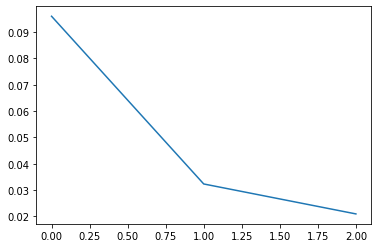

In [30]:
NUM_EPOCHS = 3
BATCH_SIZE = 64

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

hist = model.fit(train_x_cls, train_y_cls, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

plt.plot(hist.history['loss'])

model.evaluate(train_x_cls, train_y_cls)

### Пример получения входа в классификатор по пропозалу

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7ff86df350d0>)

<Figure size 432x288 with 0 Axes>

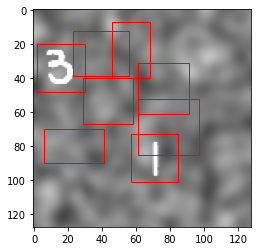

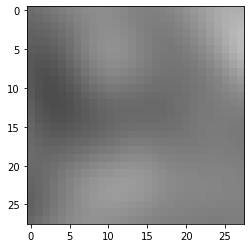

In [31]:
inp_size = (28, 28)

idx = 0
img = test_x_det[idx]
proposals_img = test_proposals[idx]
proposal = proposals_img[0]

ry, rx, rh, rw = proposal        
box_y = int(round(ry * img.shape[0]))
box_x = int(round(rx * img.shape[1]))
box_w = int(round(rw * img.shape[1]))
box_h = int(round(rh * img.shape[0]))
img_sub = img[box_y:box_y+box_h, box_x:box_x+box_w, :]     
img_inp = resize(img_sub, (inp_size[0], inp_size[1]), 
    order=3, mode='reflect', anti_aliasing=True)

# Все пропозалы
plt.figure(), show_proposals(img, proposals_img)

# Вырезанный и трансформированный пропозал
plt.figure(), plt.imshow(img_inp[...,0], 'gray', vmin=0, vmax=1,)

### Запуск детектирования объектов с помощью Fast R-CNN

In [32]:
idx = random.randint(0, 1000)
img = test_x_det[idx]
labels_true = test_y_det[idx]
proposals_img = test_proposals[idx]

preds = model(img[None, ...], proposals_img)

### Визуализация Ground-Truth

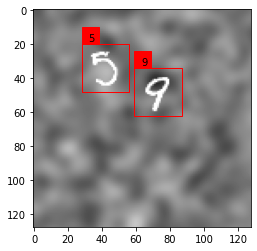

In [33]:
show_prediction(img, labels_true)

### Визуализация пропозалов

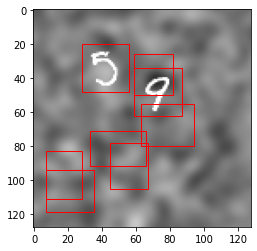

In [34]:
show_proposals(img, proposals_img)

### Визуализация детекций Fast R-CNN

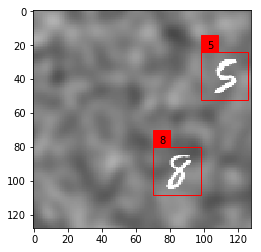

In [ ]:
show_prediction(img, preds)